In [1]:
#Importing libraries
import numpy as np
import scipy as scp
import pylab as pyl
import matplotlib.pyplot as plt
from PIL import Image
import time
import requests
from io import BytesIO
#Importing the files containing the algorithms and some display function
from algorithms import *
from visualizer import *

# Comparing numerical performance of first-order methods on a LASSO problem


We aim to solve the following problem:
$$\min\limits_{x\in \mathbb{R}^N} F(x):=\underbrace{\frac{1}{2}\|Ax-b\|^2_2}_{:=f(x)}+\underbrace{\lambda\|x\|_1}_{:=h(x)},$$
where $A\in\mathcal{M}_{N\times N}(\mathbb{R})$, $b\in\mathbb{R}^N$ and $\lambda>0$.

We can easily prove that $\nabla f(x)=A^T(Ax-b)$ and that the proximal operator of $h$ is the soft-thresholding operator:
$$\forall x \in\mathbb{R}^N,~\forall 1\leqslant i\leqslant N,~(prox_h(x))_i=\left\{\begin{aligned}x_i+\lambda~&\text{if}~x_i<\lambda\\0\quad&\text{if}~x_i\in[-\lambda,\lambda]\\ x_i-\lambda~&\text{if}~x_i>\lambda\end{aligned}\right.$$
Moreover, the gradient of $f$ is $L$-Lipschitz where $L=\sigma_{max}(A^TA)$.

In [2]:
#Defining the operators related to a set of parameter (A,b,lambda)
def operators_LASSO(A,b,lam):
    ATA=A.T.dot(A)
    ATb=A.T.dot(b)
    f = lambda x: 1/2*npl.norm(np.dot(A,x)-b)**2
    h = lambda x: lam*npl.norm(x,1)
    F = lambda x: 1/2*npl.norm(np.dot(A,x)-b)**2+lam*npl.norm(x,1)
    Df = lambda x: np.dot(ATA,x)-ATb
    proxh = lambda x,s:(x/(np.absolute(x)+1*(x==0)))*(np.absolute(x)-s*lam)*(np.absolute(x)-s*lam>0)
    return F,f,h,Df,proxh

In [81]:
#Generating the data
N=1500
A=100*np.random.rand(N,N)
b=100*np.random.rand(N)
lam=1e4
x0=(np.random.rand(N)-0.5)*100
exit_crit=lambda x,xm:npl.norm(x-xm,2) #exit criteria -> norm of the composite gradient without the normalization
sp=lambda x,y:np.dot(x,y) #scalar product
F,f,h,Df,proxh=operators_LASSO(A,b,lam)
ATA=A.T.dot(A)
L=np.max(np.absolute(npl.eig(ATA)[0])) #Computing the Lipschitz constant of the gradient of f

In [82]:
Niter=100000 #maximum number of iterations 
epsilon=1e-10 #expected accuracy

We apply first-order methods to the operators of the LASSO problem. For further details on the methods and how they are implemented, we refer to the file algorithms.py or to the cell below:

In [83]:
help(FISTA_automatic_restart)
#help(FISTA)...

Help on function FISTA_automatic_restart in module algorithms:

FISTA_automatic_restart(x, s, Niter, epsilon, Df, proxh, F, alpha=3, C=6.38, exit_crit=None, out_cost=True, estimated_ratio=1, out_mu=False, extra_function=None, track_ctime=False)
    Automatic restart of FISTA (method introduced in "FISTA restart using
    an automatic estimation of the growth parameter").
    
    Parameters
    ----------
        x : array_like
            Initial vector.
        s : float
            Step size of the method.
        Niter : integer
            Maximum number of iterations.
        epsilon: float
            Expected accuracy for the given exit criteria.
        Df : operator
            Derivative of the differentiable function f.
        proxh : operator
            Proximal operator of the non differentiable function h.
        F : operator
            Function to minimize.
        alpha : float, optional
            Inertial parameter involved in the step 
            y_k=x_k+k/(k+

In [84]:
xFB,costFB,ctimeFB=ForwardBackward(x0,1/L,Niter,epsilon,Df,proxh,F=F,exit_crit=exit_crit,track_ctime=True)
Plot_FB=To_Plot(costFB,"Forward-Backward",ctimeFB)

In [85]:
xFISTA,costFISTA,ctimeFISTA=FISTA(x0,1/L,Niter,epsilon,Df,proxh,F=F,exit_crit=exit_crit,track_ctime=True)
Plot_FISTA=To_Plot(costFISTA,"FISTA",ctimeFISTA)

In [86]:
xAR1,costAR1,ctimeAR1=FISTA_automatic_restart(x0,1/L,Niter,epsilon,Df,proxh,F,exit_crit=exit_crit,track_ctime=True)
Plot_AR1=To_Plot(costAR1,"Automatic FISTA restart by ADLR",ctimeAR1)

In [87]:
xRG,costRG,ctimeRG=FISTA_grad_restart(x0,1/L,Niter,epsilon,Df,proxh,F=F,exit_crit=exit_crit,sp=sp,track_ctime=True)
Plot_RG=To_Plot(costRG,"Empiric gradient restart",ctimeRG)

In [88]:
xRF,costRF,ctimeRF=FISTA_func_restart(x0,1/L,Niter,epsilon,Df,proxh,F=F,exit_crit=exit_crit,out_cost=True,track_ctime=True)
Plot_RF=To_Plot(costRF,"Empiric restart, rule on F",ctimeRF)

In [89]:
n0=10
xAKL,costAKL,ctimeAKL=FISTA_restart_AKL(x0,1/L,Niter,n0,epsilon,Df,proxh,F,exit_crit=exit_crit,out_cost=True,track_ctime=True)
Plot_AKL=To_Plot(costAKL,"Adaptive restart by Alamo, Krupa and Limon",ctimeAKL)

In [90]:
xAKLg,costAKLg,ctimeAKLg=FISTA_gradient_restart_AKL(x0,1/L,Niter,epsilon,Df,proxh,F=F,exit_crit=exit_crit,track_ctime=True)
Plot_AKLg=To_Plot(costAKLg,"Adaptive gradient restart by Alamo, Krupa and Limon",ctimeAKLg)

We show the convergence curves associated with the above calculations.

In [105]:
Global_Plot=[Plot_FB,Plot_FISTA,Plot_RG,Plot_RF,Plot_AKL,Plot_AKLg,Plot_AR1]

Text(0, 0.5, '$log(F(x_k)-\\hat F)$')

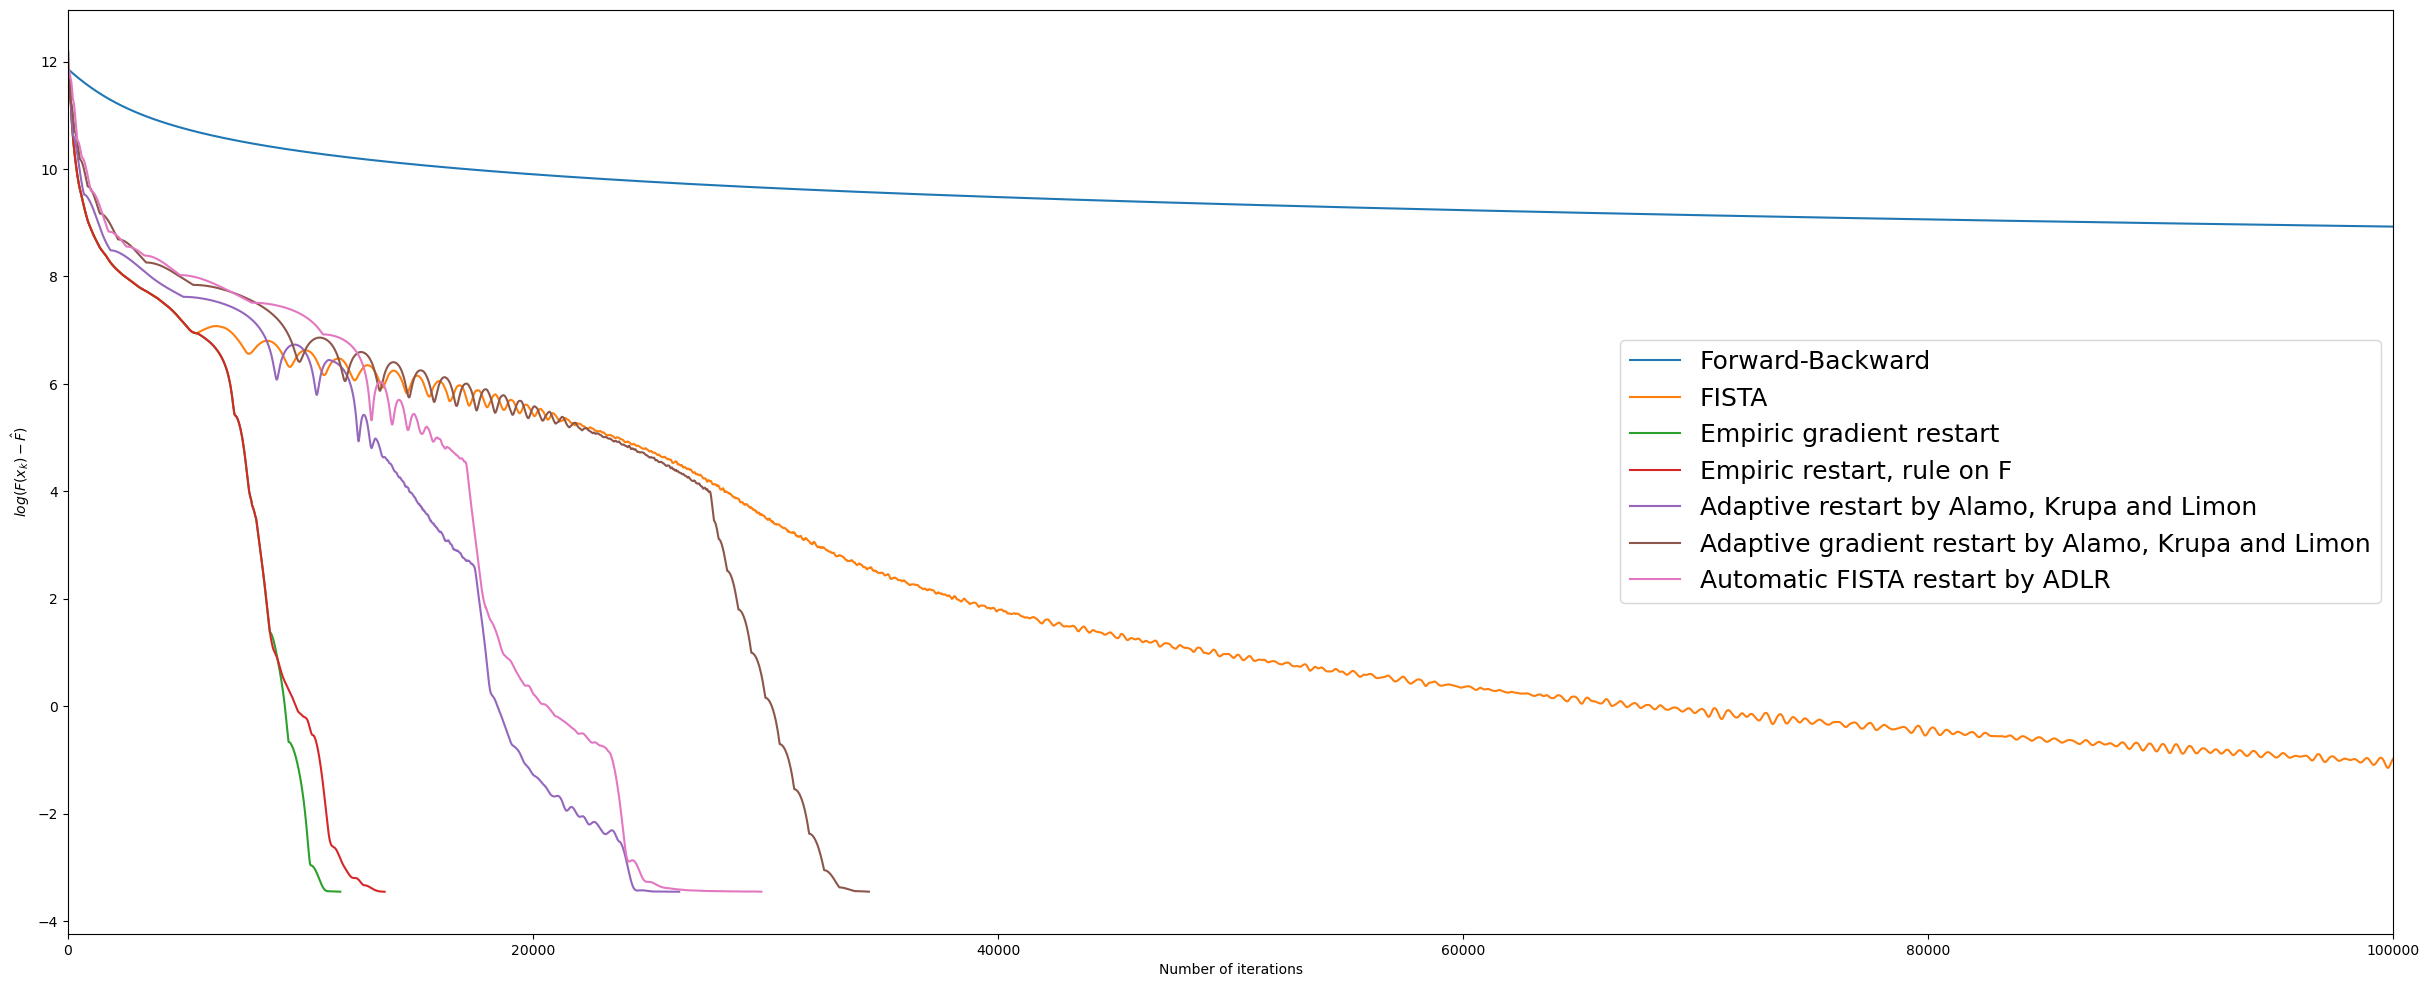

In [108]:
Plot(Global_Plot,eps=1e-9)
plt.xlabel("Number of iterations")
plt.ylabel("$log(F(x_k)-\hat F)$")

Text(0, 0.5, '$log(F(x_k)-\\hat F)$')

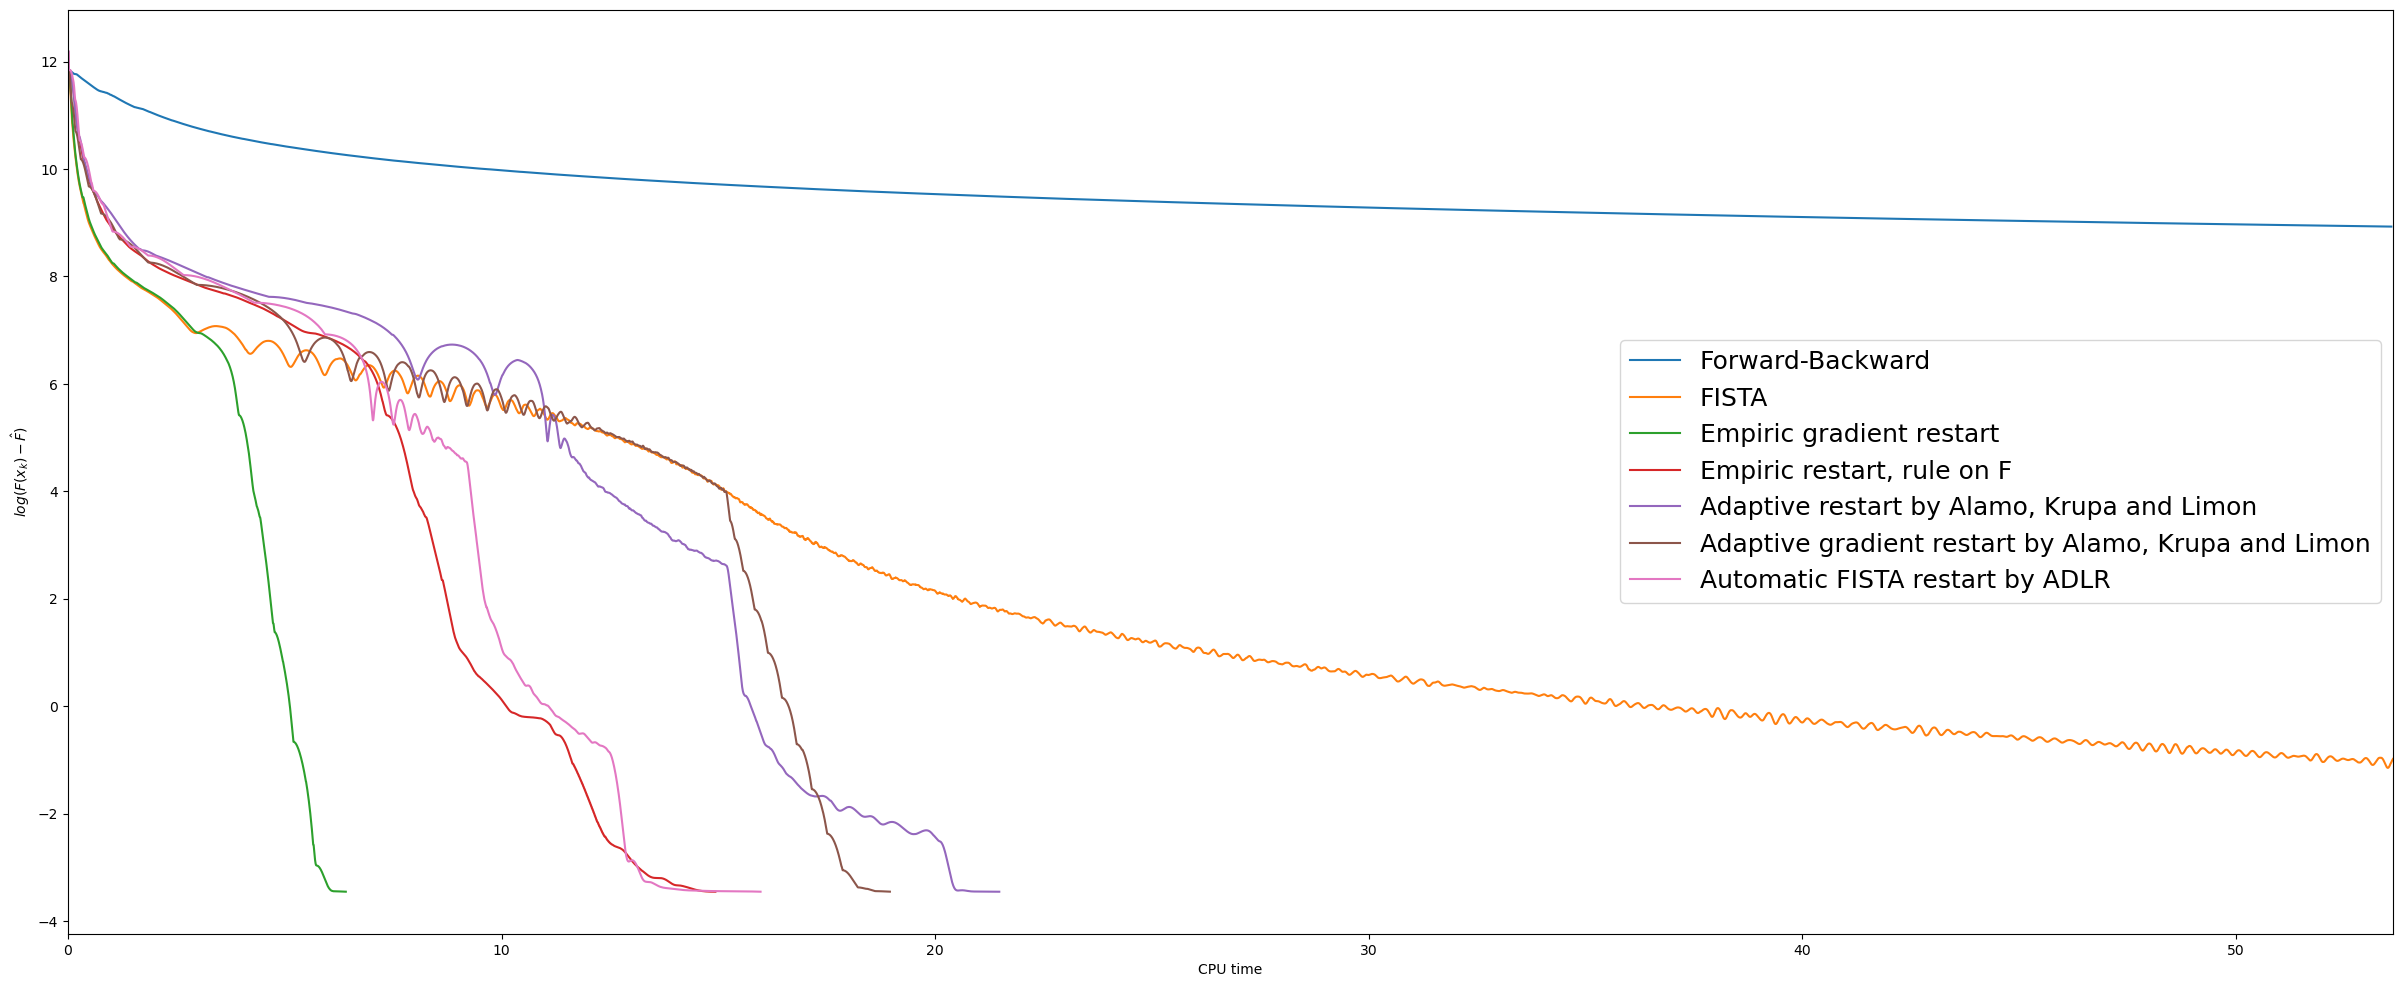

In [109]:
Plot(Global_Plot,ite=False,eps=1e-9)
plt.xlabel("CPU time (in seconds)")
plt.ylabel("$log(F(x_k)-\hat F)$")

Note that the methods were implemented generically for any function $F$ and thus, there exist ways to reduce the cost of each computation for this specific problem. Consequently, the graph above should only be seen as a performance comparison for this specific implementation of each method.